In [1]:
import pandas as pd

# Load core datasets
student_info = pd.read_csv("studentInfo.csv")         # demographics + outcome
student_vle = pd.read_csv("studentVLE.csv")           # VLE interactions
courses = pd.read_csv("courses.csv")                  # course presentation length (start/end)
vle = pd.read_csv("vle.csv")                          # learning resource types
assessments = pd.read_csv("assessments.csv")          # assessment timing (optional)

# Inspect
print(student_info.columns)
print(student_vle.columns)


Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')


In [3]:
# 1 = dropout (Withdrawn), 0 = passed or completed
student_info["event"] = student_info["final_result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

# Estimate duration using last interaction date (in days)
vle_last_day = student_vle.groupby(
    ["id_student", "code_module", "code_presentation"]
)["date"].max().reset_index()

vle_last_day.columns = ["id_student", "code_module", "code_presentation", "last_interaction_day"]

# Merge into student_info
student_info = student_info.merge(
    vle_last_day, on=["id_student", "code_module", "code_presentation"], how="left"
)

# Assign duration:
# - Dropouts: last interaction day
# - Others: assume censored at max course length (269 days)
student_info["duration"] = student_info["last_interaction_day"].fillna(269)

# Drop helper column
student_info.drop(columns=["last_interaction_day"], inplace=True)


In [4]:
# Keep only interactions from days 0 to 35 (weeks 0–5)
early_vle = student_vle[student_vle["date"] <= 35]

# Quick look
early_vle.head()


,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [5]:
# Remove invalid negative dates (pre-course interactions)
student_vle = student_vle[student_vle["date"] >= 0]

# Now filter to early weeks: 0–5 = days 0 to 35
early_vle = student_vle[student_vle["date"] <= 35]

# Quick check
print(f"Filtered to {early_vle.shape[0]} early VLE records (0–35 days)")
early_vle.head()


Filtered to 2564918 early VLE records (0–35 days)


,code_module,code_presentation,id_student,id_site,date,sum_click
10847,AAA,2013J,345357,546667,0,3
10848,AAA,2013J,345357,546883,0,1
10849,AAA,2013J,345357,546732,0,14
10850,AAA,2013J,345357,546614,0,5
10851,AAA,2013J,345357,546876,0,1


In [6]:
# Group by student/module and engineer features
vle_features = early_vle.groupby(
    ["id_student", "code_module", "code_presentation"]
).agg(
    total_clicks=("sum_click", "sum"),
    mean_clicks=("sum_click", "mean"),
    std_clicks=("sum_click", "std"),
    active_days=("date", "nunique"),
    first_day=("date", "min"),
    last_day=("date", "max")
).reset_index()

# Add engagement window length
vle_features["engagement_span"] = vle_features["last_day"] - vle_features["first_day"]


In [7]:
# Merge aggregated VLE features with main student info
survival_df = student_info.merge(
    vle_features, on=["id_student", "code_module", "code_presentation"], how="left"
)

# Fill missing VLE engagement values (for students with no activity in weeks 0–5)
vle_cols = ["total_clicks", "mean_clicks", "std_clicks", "active_days", "first_day", "last_day", "engagement_span"]
survival_df[vle_cols] = survival_df[vle_cols].fillna(0)

# Final check
print("✅ survival_df shape:", survival_df.shape)
survival_df[["id_student", "code_module", "code_presentation", "duration", "event"] + vle_cols].head()


✅ survival_df shape: (32593, 21)


,id_student,code_module,code_presentation,duration,event,total_clicks,mean_clicks,std_clicks,active_days,first_day,last_day,engagement_span
0,11391,AAA,2013J,253.0,0,329.0,5.771930,10.753766,10.0,0.0,31.0,31.0
1,28400,AAA,2013J,239.0,0,410.0,3.727273,3.565660,15.0,0.0,34.0,34.0
2,30268,AAA,2013J,12.0,1,179.0,4.261905,4.231471,6.0,4.0,12.0,8.0
3,31604,AAA,2013J,264.0,0,397.0,3.176000,2.732906,22.0,1.0,34.0,33.0
4,32885,AAA,2013J,247.0,0,290.0,3.295455,3.231167,17.0,1.0,32.0,31.0


In [9]:
from sklearn.model_selection import train_test_split

# List of unique course modules
all_modules = survival_df["code_module"].unique()
print("All modules:", all_modules)

# Random 70/30 split of modules
train_modules, test_modules = train_test_split(all_modules, test_size=0.3, random_state=42)

# Select rows from survival_df based on those modules
train_df = survival_df[survival_df["code_module"].isin(train_modules)].copy()
test_df = survival_df[survival_df["code_module"].isin(test_modules)].copy()

print("Before leakage control:")
print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")


All modules: ['AAA' 'BBB' 'CCC' 'DDD' 'EEE' 'FFF' 'GGG']
Before leakage control:
Train set: (16174, 21)
Test set: (16419, 21)


In [10]:
# Prevent student leakage
train_students = set(train_df["id_student"])
test_students = set(test_df["id_student"])

overlap = train_students.intersection(test_students)
print(f"Overlapping students: {len(overlap)}")

# Drop overlapping students from test set
test_df = test_df[~test_df["id_student"].isin(overlap)]

print("✅ After leakage removal:")
print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")


Overlapping students: 688
✅ After leakage removal:
Train set: (16174, 21)
Test set: (15692, 21)


In [11]:
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter

# 1. Define features
features = [
    "gender", "region", "highest_education", "age_band", "disability",
    "total_clicks", "mean_clicks", "std_clicks", "active_days", "engagement_span"
]

# 2. Preprocess function (dummy encoding)
def preprocess(df):
    df_model = df[features + ["duration", "event"]].copy()
    df_model = pd.get_dummies(df_model, columns=["gender", "region", "highest_education", "age_band", "disability"], drop_first=True)
    return df_model

X_train = preprocess(train_df)
X_test = preprocess(test_df)

# 3. Standardize numeric features
num_cols = ["total_clicks", "mean_clicks", "std_clicks", "active_days", "engagement_span"]
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [12]:
# 4. Fit Cox model
cph = CoxPHFitter()
cph.fit(X_train, duration_col="duration", event_col="event")

# Display model summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 16174 total observations, 10935 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 16174
number of events observed = 5239
   partial log-likelihood = -45836.61
         time fit was run = 2025-07-11 23:52:36 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                      
total_clicks                                  -0.47      0.63      0.05           -0.56           -0.38                0.57                0.69
mean_clicks                                    0.38      1.46      0.03            0.32            0.44                1.38                1.55
std_clicks                                    -0.12      0.88      0.04           -0.19           -0.05                0.83                0.95
active_days                                    0.05      1.05      0.04           -0.04            0.13                0.96                1.14
engagement_span                               -0.39      0.67      0.03           -0.45           -0.34                0.64                0.71
gender_M                                       0.22      1.24      0.03            0.16            0.28                1.17                1.32
region_East Midlands Region                    0.17      1.18      0.07            0.04            0.30                1.04                1.35
region_Ireland                                 0.28      1.32      0.10            0.08            0.48                1.08                1.62
region_London Region                           0.11      1.12      0.06           -0.01            0.23                0.99                1.26
region_North Region                            0.24      1.28      0.07            0.11            0.38                1.11                1.47
region_North Western Region                    0.18      1.19      0.06            0.05            0.30                1.06                1.34
region_Scotland                                0.04      1.04      0.06           -0.08            0.16                0.92                1.18
region_South East Region                       0.10      1.11      0.07           -0.03            0.24                0.97                1.27
region_South Region                            0.03      1.03      0.06           -0.10            0.15                0.91                1.17
region_South West Region                       0.12      1.12      0.07           -0.01            0.25                0.99                1.28
region_Wales                                   0.36      1.43      0.08            0.21            0.51                1.23                1.66
region_West Midlands Region                    0.25      1.28      0.06            0.12            0.38                1.13                1.46
region_Yorkshire Region                        0.19      1.21      0.07            0.05            0.33                1.05                1.39
highest_education_HE Qualification             0.11      1.11      0.04            0.02            0.19                1.02                1.21
highest_education_Lower Than A Level           0.04      1.04      0.03           -0.02            0.10                0.98                1.10
highest_education_No Formal quals              0.27      1.31      0.12            0.03            0.52                1.03                1.68
highest_education_Post Graduate Qualification  0.03      1.03      0.13           -0.23            0.30                0.79                1.35
age_band_35-55                                -0.07      0.93      0.03           -0.13           -0.00                0.88                1.00
age_band_55<=                 

In [13]:
# 5. Concordance index (ranking accuracy)
train_c_index = cph.concordance_index_
test_c_index = cph.score(X_test, scoring_method="concordance_index")

print(f"✅ Concordance Index (Train): {train_c_index:.4f}")
print(f"✅ Concordance Index (Test):  {test_c_index:.4f}")


✅ Concordance Index (Train): 0.6590
✅ Concordance Index (Test):  0.6292


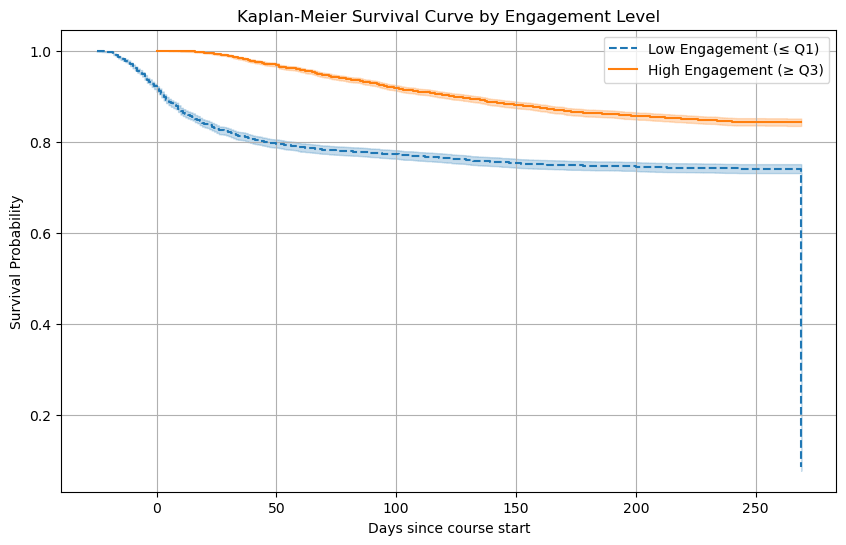

In [14]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# 1. Define quartile-based engagement groups
q75 = survival_df["total_clicks"].quantile(0.75)
q25 = survival_df["total_clicks"].quantile(0.25)

low_engaged = survival_df[survival_df["total_clicks"] <= q25]
high_engaged = survival_df[survival_df["total_clicks"] >= q75]

# 2. Fit KM models
kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

# 3. Plot survival curves
plt.figure(figsize=(10,6))

kmf_low.fit(low_engaged["duration"], event_observed=low_engaged["event"], label="Low Engagement (≤ Q1)")
kmf_low.plot(ci_show=True, linestyle="--")

kmf_high.fit(high_engaged["duration"], event_observed=high_engaged["event"], label="High Engagement (≥ Q3)")
kmf_high.plot(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by Engagement Level")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


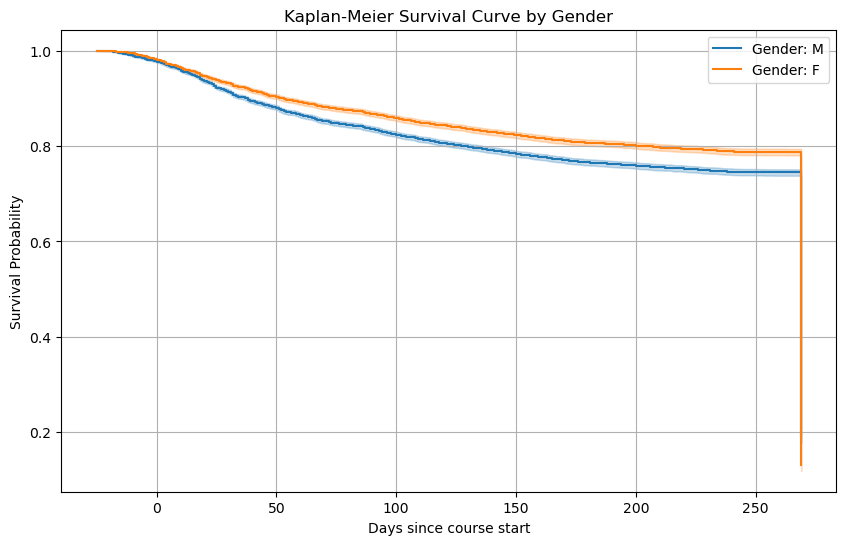

In [15]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Create separate KM curves for each gender
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))

for gender_value in survival_df["gender"].unique():
    group = survival_df[survival_df["gender"] == gender_value]
    kmf.fit(group["duration"], event_observed=group["event"], label=f"Gender: {gender_value}")
    kmf.plot(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by Gender")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


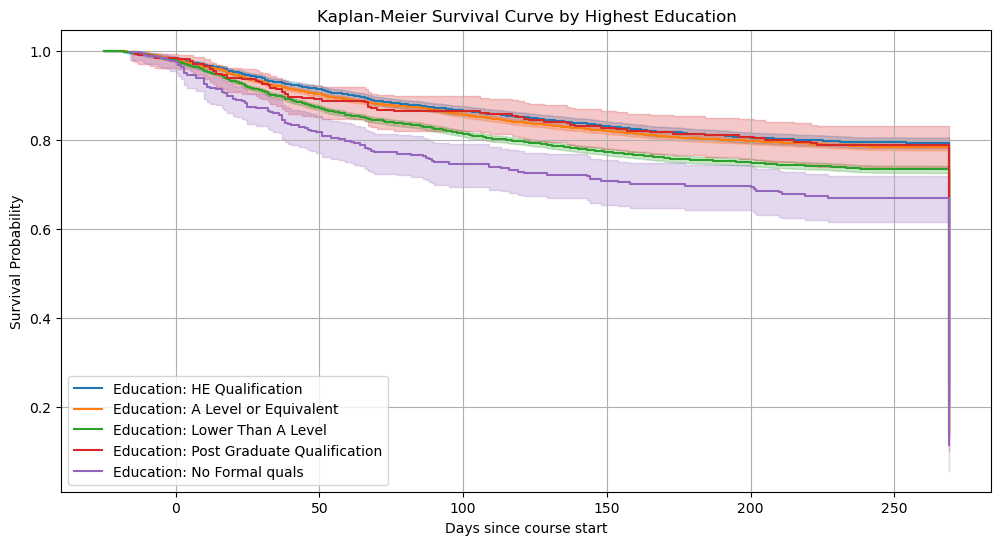

In [16]:
plt.figure(figsize=(12,6))

for edu_level in survival_df["highest_education"].unique():
    group = survival_df[survival_df["highest_education"] == edu_level]
    kmf.fit(group["duration"], event_observed=group["event"], label=f"Education: {edu_level}")
    kmf.plot(ci_show=True)

plt.title("Kaplan-Meier Survival Curve by Highest Education")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


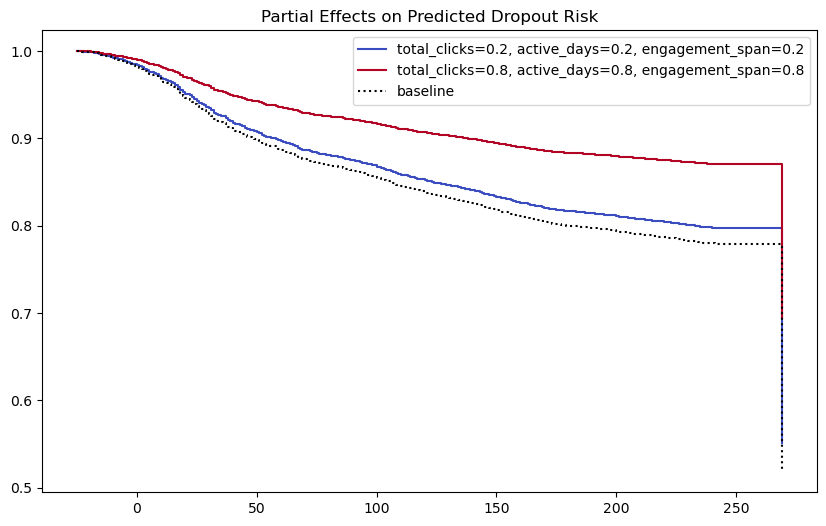

In [17]:
# Partial effect plots for top 10 features (ranked by effect size)
cph.plot_partial_effects_on_outcome(covariates=["total_clicks", "active_days", "engagement_span"], 
                                     values=[[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]],
                                     cmap="coolwarm",
                                     figsize=(10,6))
plt.title("Partial Effects on Predicted Dropout Risk")
plt.show()


In [18]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
import numpy as np

# List of modules to treat as folds
modules = survival_df["code_module"].unique()
concordances = []

for test_mod in modules:
    # Split: one module for test, rest for train
    train_df = survival_df[survival_df["code_module"] != test_mod].copy()
    test_df = survival_df[survival_df["code_module"] == test_mod].copy()

    # Remove any overlapping students
    train_ids = set(train_df["id_student"])
    test_df = test_df[~test_df["id_student"].isin(train_ids)]

    # Preprocess features
    def preprocess(df):
        df_model = df[features + ["duration", "event"]].copy()
        df_model = pd.get_dummies(df_model, columns=["gender", "region", "highest_education", "age_band", "disability"], drop_first=True)
        return df_model

    X_train = preprocess(train_df)
    X_test = preprocess(test_df)

    # Align columns in case some dummies are missing in test
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]

    # Standardize numeric columns
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    # Fit Cox model
    cph = CoxPHFitter()
    cph.fit(X_train, duration_col="duration", event_col="event")

    # Score on test set
    c_index = cph.score(X_test, scoring_method="concordance_index")
    concordances.append(c_index)

    print(f"✅ Module {test_mod}: C-index = {c_index:.4f}")

# Report average performance
print(f"\n✅ Average C-index across modules: {np.mean(concordances):.4f}")


✅ Module AAA: C-index = 0.5657
✅ Module BBB: C-index = 0.6219
✅ Module CCC: C-index = 0.6765
✅ Module DDD: C-index = 0.6724
✅ Module EEE: C-index = 0.7178
✅ Module FFF: C-index = 0.6798
✅ Module GGG: C-index = 0.5843

✅ Average C-index across modules: 0.6455


In [19]:
import pandas as pd

# Construct module-wise C-index DataFrame
cv_results = pd.DataFrame({
    "code_module": ["AAA", "BBB", "CCC", "DDD", "EEE", "FFF", "GGG"],
    "c_index": [0.5657, 0.6219, 0.6765, 0.6724, 0.7178, 0.6798, 0.5843]
})

# Add average row (optional)
cv_results.loc[len(cv_results.index)] = ["Average", cv_results["c_index"].mean()]

# Save to CSV
cv_results.to_csv("coxph_cv_results_by_module.csv", index=False)

print("✅ Module-wise concordance scores saved to 'coxph_cv_results_by_module.csv'")


✅ Module-wise concordance scores saved to 'coxph_cv_results_by_module.csv'


#Explore module aaa

In [20]:
# Extract only students from AAA
aaa_df = survival_df[survival_df["code_module"] == "AAA"].copy()

# Dropout rate
dropout_rate = aaa_df["event"].mean()
print(f"📉 Dropout rate in AAA: {dropout_rate:.2%}")
print(f"📦 Number of students in AAA: {len(aaa_df)}")

# Feature distribution (summary stats)
aaa_df[["total_clicks", "mean_clicks", "std_clicks", "active_days", "engagement_span"]].describe()


📉 Dropout rate in AAA: 16.84%
📦 Number of students in AAA: 748


,total_clicks,mean_clicks,std_clicks,active_days,engagement_span
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,412.705882,3.576428,3.765765,16.061497,27.844920
std,418.526294,1.265312,2.067098,9.268794,9.134281
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,148.000000,2.896247,2.737187,9.000000,26.000000
50%,306.500000,3.539649,3.569472,15.000000,32.000000
75%,526.000000,4.209772,4.504873,23.000000,34.000000
max,3626.000000,10.449568,31.351983,36.000000,35.000000


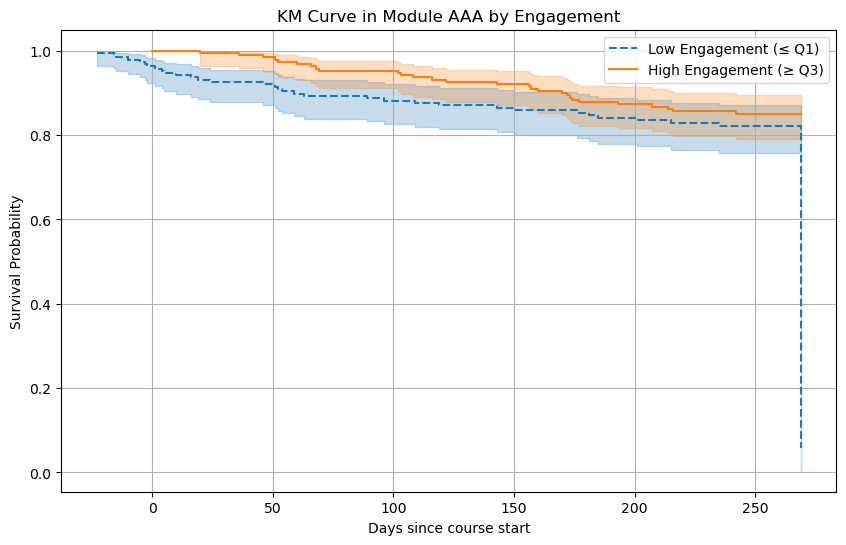

In [21]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Quartile thresholds within AAA
q75 = aaa_df["total_clicks"].quantile(0.75)
q25 = aaa_df["total_clicks"].quantile(0.25)

low_eng = aaa_df[aaa_df["total_clicks"] <= q25]
high_eng = aaa_df[aaa_df["total_clicks"] >= q75]

# Plot KM survival
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
kmf.fit(low_eng["duration"], low_eng["event"], label="Low Engagement (≤ Q1)")
kmf.plot(ci_show=True, linestyle="--")

kmf.fit(high_eng["duration"], high_eng["event"], label="High Engagement (≥ Q3)")
kmf.plot(ci_show=True)

plt.title("KM Curve in Module AAA by Engagement")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


Compare AAA vs. EEE Side-by-Side

In [22]:
# Filter both modules
eee_df = survival_df[survival_df["code_module"] == "EEE"].copy()

# Dropout rates
dropout_aaa = aaa_df["event"].mean()
dropout_eee = eee_df["event"].mean()

print(f"📉 Dropout Rate - AAA: {dropout_aaa:.2%} | Students: {len(aaa_df)}")
print(f"📉 Dropout Rate - EEE: {dropout_eee:.2%} | Students: {len(eee_df)}")

# Feature comparison
print("\n📊 Mean Total Clicks (Early Weeks):")
print(f"AAA: {aaa_df['total_clicks'].mean():.1f}")
print(f"EEE: {eee_df['total_clicks'].mean():.1f}")


📉 Dropout Rate - AAA: 16.84% | Students: 748
📉 Dropout Rate - EEE: 24.61% | Students: 2934

📊 Mean Total Clicks (Early Weeks):
AAA: 412.7
EEE: 353.8


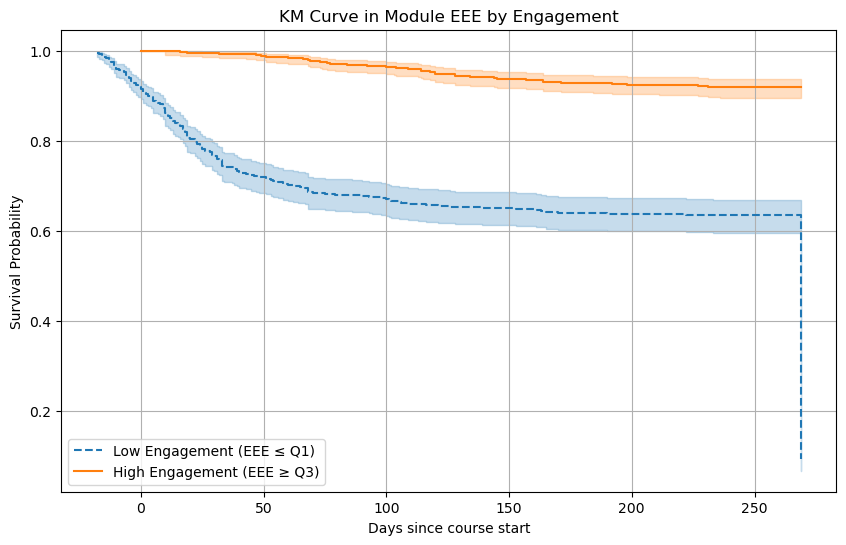

In [23]:
# Define quartiles in EEE
q75_eee = eee_df["total_clicks"].quantile(0.75)
q25_eee = eee_df["total_clicks"].quantile(0.25)

low_eng_eee = eee_df[eee_df["total_clicks"] <= q25_eee]
high_eng_eee = eee_df[eee_df["total_clicks"] >= q75_eee]

# KM plot
kmf = KaplanMeierFitter()
plt.figure(figsize=(10,6))

kmf.fit(low_eng_eee["duration"], low_eng_eee["event"], label="Low Engagement (EEE ≤ Q1)")
kmf.plot(ci_show=True, linestyle="--")

kmf.fit(high_eng_eee["duration"], high_eng_eee["event"], label="High Engagement (EEE ≥ Q3)")
kmf.plot(ci_show=True)

plt.title("KM Curve in Module EEE by Engagement")
plt.xlabel("Days since course start")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()


time varying covariates

In [24]:
# Filter studentVLE to days 0–41 to cover full weeks 0–5
vle_weekly = student_vle[(student_vle["date"] >= 0) & (student_vle["date"] <= 41)].copy()

# Map date to week number (0-based)
vle_weekly["week"] = vle_weekly["date"] // 7

# Sum clicks per student/module/week
weekly_clicks = vle_weekly.groupby(["id_student", "code_module", "code_presentation", "week"])["sum_click"].sum().reset_index()
weekly_clicks.rename(columns={"sum_click": "clicks"}, inplace=True)

# Expand to all weeks (0–5), even if no activity
full_weeks = pd.MultiIndex.from_product([
    student_info["id_student"].unique(),
    student_info["code_module"].unique(),
    student_info["code_presentation"].unique(),
    range(6)
], names=["id_student", "code_module", "code_presentation", "week"]).to_frame(index=False)

weekly_df = pd.merge(full_weeks, weekly_clicks, on=["id_student", "code_module", "code_presentation", "week"], how="left")
weekly_df["clicks"] = weekly_df["clicks"].fillna(0)


In [25]:
# Merge student survival info
weekly_df = weekly_df.merge(
    student_info[["id_student", "code_module", "code_presentation", "duration", "event"]],
    on=["id_student", "code_module", "code_presentation"],
    how="left"
)

# Compute (start, stop) intervals in days
weekly_df["start"] = weekly_df["week"] * 7
weekly_df["stop"] = weekly_df["start"] + 7

# Filter to rows within student's duration
weekly_df = weekly_df[weekly_df["start"] < weekly_df["duration"]].copy()
weekly_df["stop"] = weekly_df[["stop", "duration"]].min(axis=1)

# Set event = 1 only in final interval
weekly_df["event_at_stop"] = ((weekly_df["stop"] == weekly_df["duration"]) & (weekly_df["event"] == 1)).astype(int)


In [26]:
# Preview first few rows
weekly_df[["id_student", "start", "stop", "clicks", "event_at_stop"]].head()


,id_student,start,stop,clicks,event_at_stop
0,11391,0,7.0,183.0,0
1,11391,7,14.0,20.0,0
2,11391,14,21.0,100.0,0
3,11391,21,28.0,0.0,0
4,11391,28,35.0,26.0,0


In [27]:
# Merge demographics (time-invariant covariates)
demographics = student_info[[
    "id_student", "code_module", "code_presentation",
    "gender", "region", "highest_education", "age_band", "disability"
]]

weekly_df = weekly_df.merge(demographics, on=["id_student", "code_module", "code_presentation"], how="left")

# One-hot encode categorical variables (drop_first avoids multicollinearity)
weekly_df = pd.get_dummies(
    weekly_df,
    columns=["gender", "region", "highest_education", "age_band", "disability"],
    drop_first=True
)


In [28]:
# Rename required columns
weekly_df = weekly_df.rename(columns={
    "id_student": "id",
    "event_at_stop": "event"
})

# Sanity check
weekly_df[["id", "start", "stop", "clicks", "event"]].head()


,id,start,stop,clicks,event,event
0,11391,0,7.0,183.0,0.0,0
1,11391,7,14.0,20.0,0.0,0
2,11391,14,21.0,100.0,0.0,0
3,11391,21,28.0,0.0,0.0,0
4,11391,28,35.0,26.0,0.0,0


In [29]:
# Check column names
print(weekly_df.columns)


Index(['id', 'code_module', 'code_presentation', 'week', 'clicks', 'duration',
       'event', 'start', 'stop', 'event', 'gender_M',
       'region_East Midlands Region', 'region_Ireland', 'region_London Region',
       'region_North Region', 'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'age_band_35-55',
       'age_band_55<=', 'disability_Y'],
      dtype='object')


In [30]:
# Drop the incorrect 'event' column from student_info merge
weekly_df = weekly_df.drop(columns=["event"])  # drop the conflicting one

# Now rename the correct one
weekly_df = weekly_df.rename(columns={"event_at_stop": "event"})


In [31]:
print([col for col in weekly_df.columns if "event" in col])


[]


In [32]:
from lifelines import CoxTimeVaryingFitter

# Recreate the list of covariates
model_cols = ["id", "start", "stop", "event", "clicks"] + \
             [col for col in weekly_df.columns if col.startswith(('gender_', 'region_', 'highest_education_', 'age_band_', 'disability_'))]

# Final dataset for modeling
tv_df = weekly_df[model_cols].copy()

# Fit the model
ctv = CoxTimeVaryingFitter()
ctv.fit(tv_df, id_col="id", start_col="start", stop_col="stop", event_col="event")

# View summary
ctv.print_summary()


KeyError: "['event'] not in index"

In [33]:
# Check which event-like columns still exist
print([col for col in weekly_df.columns if 'event' in col])


[]


In [34]:
# Sanity check: ensure you still have original event and duration columns
assert "duration" in weekly_df.columns
assert "event" not in weekly_df.columns  # we are going to recreate it

# Bring in original dropout indicator from student_info
event_map = student_info[["id_student", "code_module", "code_presentation", "event"]]

# Rename for clarity
event_map = event_map.rename(columns={"id_student": "id", "event": "original_event"})

# Merge original event info back
weekly_df = weekly_df.merge(event_map, on=["id", "code_module", "code_presentation"], how="left")

# Recreate correct event column (event only at final interval)
weekly_df["event"] = ((weekly_df["stop"] == weekly_df["duration"]) & (weekly_df["original_event"] == 1)).astype(int)

# Final check
print(weekly_df[["id", "start", "stop", "clicks", "event"]].head())


      id  start  stop  clicks  event
0  11391      0   7.0   183.0      0
1  11391      7  14.0    20.0      0
2  11391     14  21.0   100.0      0
3  11391     21  28.0     0.0      0
4  11391     28  35.0    26.0      0
